# Essai pre-traitement du dataset

## Librairies importation

In [1]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting, image
from nipype.interfaces.fsl import BET, FLIRT, MCFLIRT
from nipype.algorithms.misc import Gunzip
from nipype import Node, Workflow

# Définir les chemins
dataset_path = '/home/rduchadeau/Desktop/Brainhack_school/duchadeau_project/ds003768-download/'
fmri_path_sub_01_sess_01 = os.path.join(dataset_path, 'sub-01/func/sub-01_task-rest_run-1_bold.nii.gz')
t1_img_path = os.path.join(dataset_path, 'sub-01/anat/sub-01_T1w.nii.gz')


## Function definition

In [15]:
# Fonction pour visualiser une image 3D
def visualize_3d_img(img, title):
    plotting.plot_anat(img, title=title)
    plt.show()

# Fonction pour visualiser une image 4D (premier volume)
def visualize_4d_img(img, title):
    first_volume = image.index_img(img, 0)
    plotting.plot_epi(first_volume, title=title)
    plt.show()


## 1. Decompression of fMRI data

240607-11:21:47,981 nipype.workflow INFO:
	 [Node] Setting-up "gunzip_func" in "/tmp/tmpnp2ntlm1/gunzip_func".
240607-11:21:47,985 nipype.workflow INFO:
	 [Node] Executing "gunzip_func" <nipype.algorithms.misc.Gunzip>
240607-11:21:49,297 nipype.workflow INFO:
	 [Node] Finished "gunzip_func", elapsed time 1.309875s.


/home/rduchadeau/miniconda3/lib/python3.12/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(


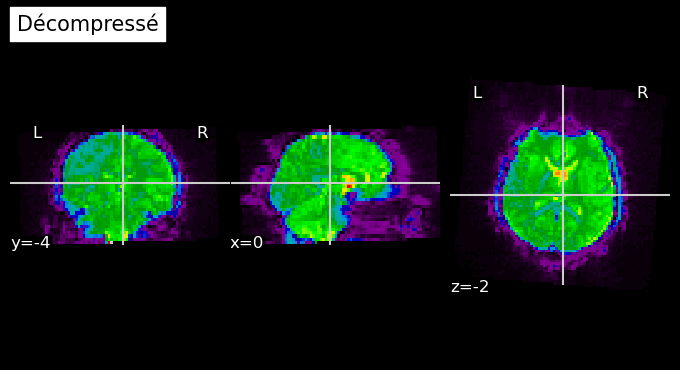

In [18]:
# Définir le noeud pour la décompression des fichiers gzip
gunzip_node = Node(Gunzip(), name='gunzip_func')
gunzip_node.inputs.in_file = fmri_path_sub_01_sess_01

# Exécuter Gunzip
gunzip_res = gunzip_node.run()

# Visualiser l'image décompressée
decompressed_img = nib.load(gunzip_res.outputs.out_file)
visualize_4d_img(decompressed_img, "Décompressé")

## 2. Mouvement correction

240607-11:22:43,200 nipype.workflow INFO:
	 [Node] Setting-up "mcflirt" in "/tmp/tmpj5hd9o7k/mcflirt".
240607-11:22:43,205 nipype.workflow INFO:
	 [Node] Executing "mcflirt" <nipype.interfaces.fsl.preprocess.MCFLIRT>
240607-11:23:57,983 nipype.workflow INFO:
	 [Node] Finished "mcflirt", elapsed time 74.775702s.


/home/rduchadeau/miniconda3/lib/python3.12/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(


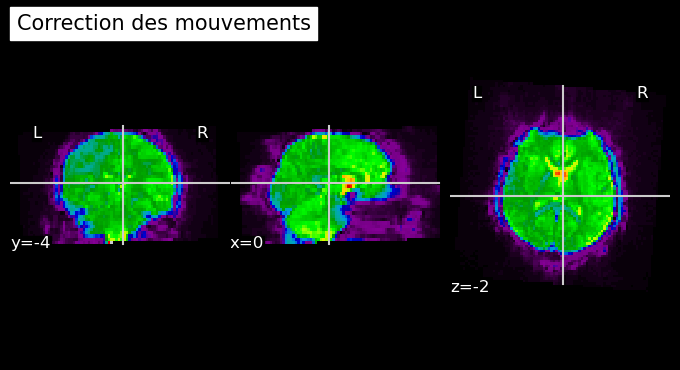

In [19]:
# Définir le noeud pour la correction des mouvements
mcflirt_node = Node(MCFLIRT(), name='mcflirt')
mcflirt_node.inputs.out_file = 'mcflirt_corrected.nii.gz'
mcflirt_node.inputs.in_file = gunzip_res.outputs.out_file

# Exécuter MCFLIRT pour la correction des mouvements
mcflirt_res = mcflirt_node.run()

# Visualiser l'image corrigée des mouvements
mcflirt_img = nib.load(mcflirt_res.outputs.out_file)
visualize_4d_img(mcflirt_img, "Correction des mouvements")

## 3. Brain extraction with BET

### Find the good extraction parameters

240607-11:41:03,913 nipype.workflow INFO:
	 [Node] Setting-up "extract" in "/tmp/tmpq4a9i9_g/extract".


240607-11:41:03,920 nipype.workflow INFO:
	 [Node] Executing "extract" <nipype.interfaces.fsl.preprocess.BET>
240607-11:41:05,457 nipype.workflow INFO:
	 [Node] Finished "extract", elapsed time 1.53506s.
240607-11:41:05,484 nipype.workflow INFO:
	 [Node] Setting-up "extract" in "/tmp/tmpq4a9i9_g/extract".
240607-11:41:05,486 nipype.workflow INFO:
	 [Node] Cached "extract" - collecting precomputed outputs
240607-11:41:05,487 nipype.workflow INFO:
	 [Node] "extract" found cached.
240607-11:41:05,507 nipype.workflow INFO:
	 [Node] Setting-up "extract" in "/tmp/tmpq4a9i9_g/extract".
240607-11:41:05,509 nipype.workflow INFO:
	 [Node] Cached "extract" - collecting precomputed outputs
240607-11:41:05,510 nipype.workflow INFO:
	 [Node] "extract" found cached.
240607-11:41:05,531 nipype.workflow INFO:
	 [Node] Setting-up "extract" in "/tmp/tmpq4a9i9_g/extract".
240607-11:41:05,533 nipype.workflow INFO:
	 [Node] Cached "extract" - collecting precomputed outputs
240607-11:41:05,534 nipype.workflo

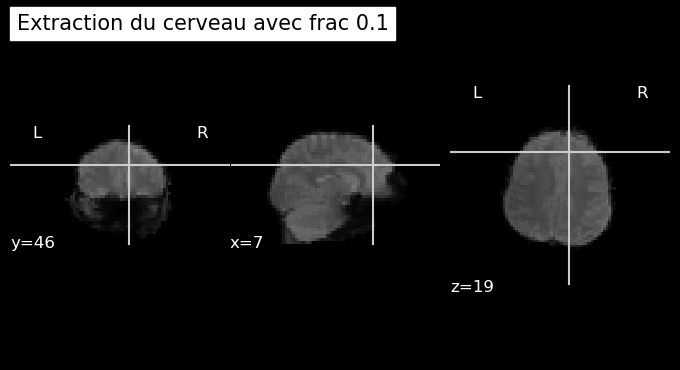

/home/rduchadeau/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



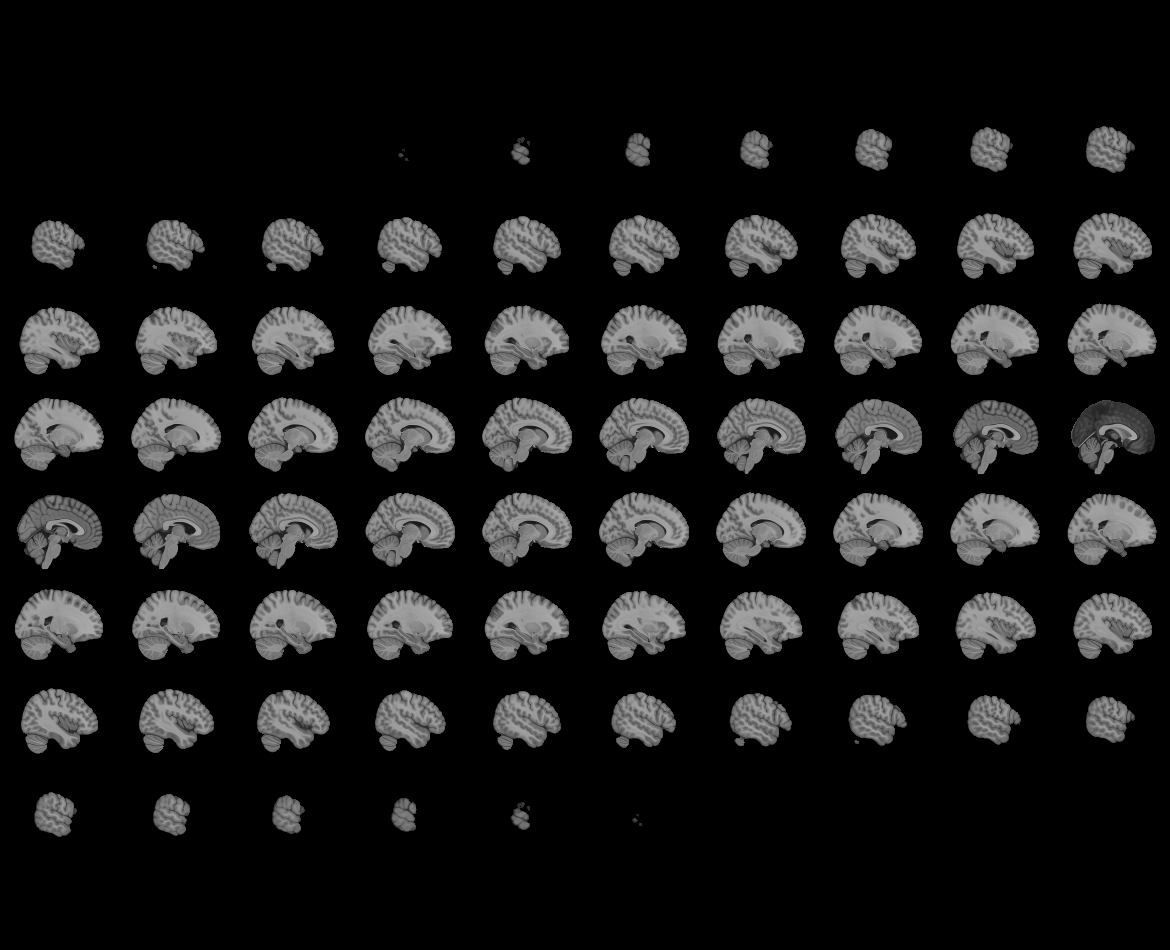
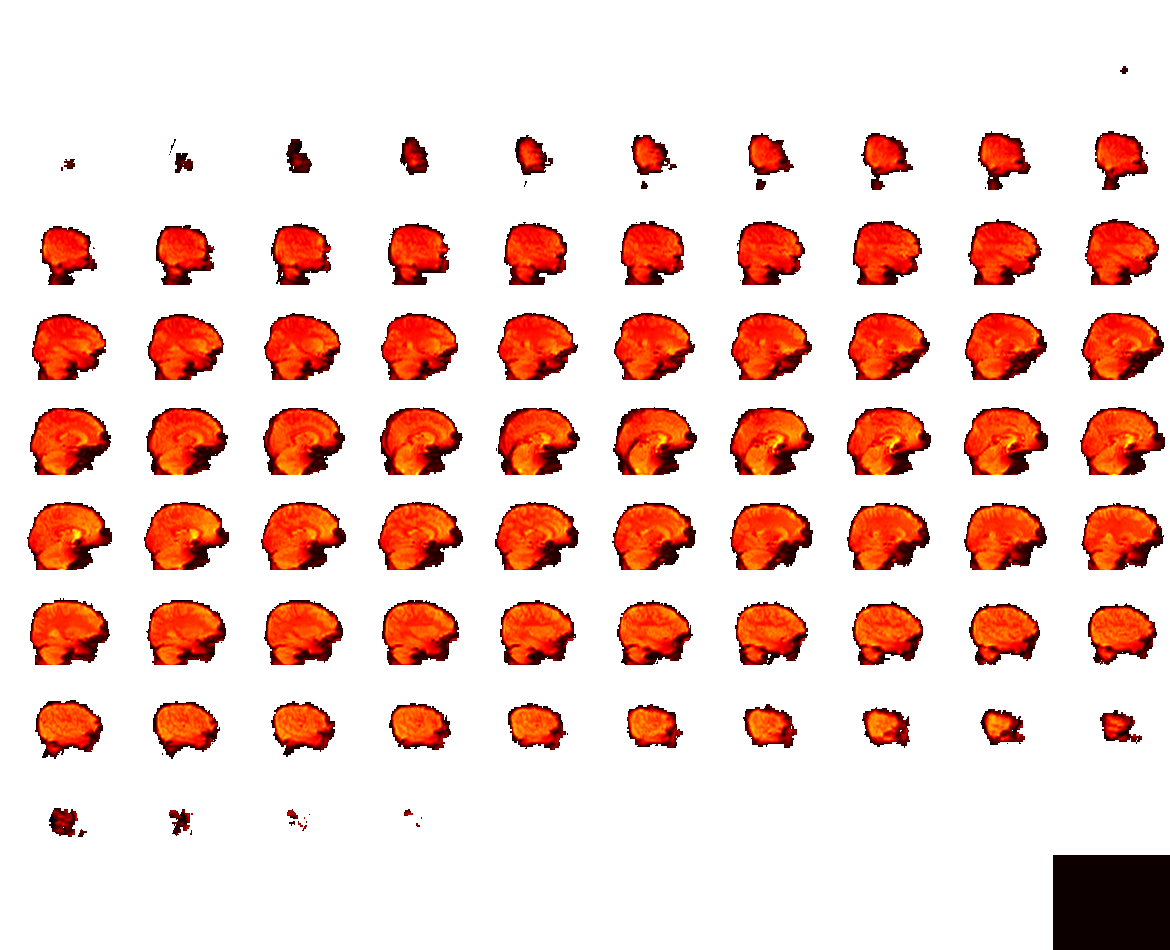

In [23]:

def calculate_criteria(image_data):
    brain_region = image_data[image_data > np.mean(image_data)]
    non_brain_region = image_data[image_data <= np.mean(image_data)]
    variance = np.var(brain_region)
    contrast = np.mean(brain_region) - np.mean(non_brain_region)
    criteria = variance * contrast
    return criteria

# Définir le noeud pour l'extraction avec BET
bet_node = Node(BET(), name='extract')
bet_node.inputs.out_file = 'output_brain.nii.gz'

# Extraire le premier volume de l'image corrigée des mouvements pour BET
first_vol_path = os.path.join('/home/rduchadeau/Desktop/Brainhack_school/duchadeau_project/working_directory', 'mcflirt_first_vol.nii.gz')
first_volume = image.index_img(mcflirt_img, 0)
nib.save(first_volume, first_vol_path)

# Initialisation pour trouver la meilleure fraction
best_extracted_img = None
best_frac = None
best_criteria = -np.inf

# Parcourir différentes valeurs de la fraction pour trouver la meilleure extraction
for frac in np.arange(0.1, 0.9, 0.1):
    bet_node.inputs.frac = frac
    bet_node.inputs.in_file = first_vol_path
    bet_res = bet_node.run()
    
    extracted_img = nib.load(bet_res.outputs.out_file)
    extracted_data = extracted_img.get_fdata()
    
    current_criteria = calculate_criteria(extracted_data)
    if current_criteria > best_criteria:
        best_extracted_img = extracted_img
        best_frac = frac
        best_criteria = current_criteria

print(f"Meilleure fraction pour BET: {best_frac}")

visualize_3d_img(best_extracted_img, f"Extraction du cerveau avec frac {best_frac}")
plotting.view_img(best_extracted_img, title= f"Extraction du cerveau avec frac {best_frac}")

## 4. Verification de l'alignement avec le T1

Vérification de l'alignement : 


/home/rduchadeau/miniconda3/lib/python3.12/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(


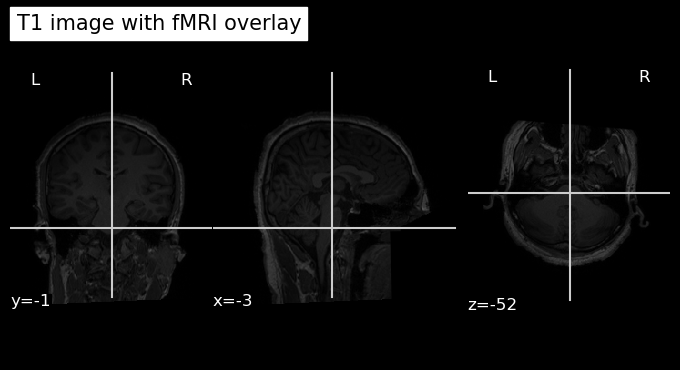

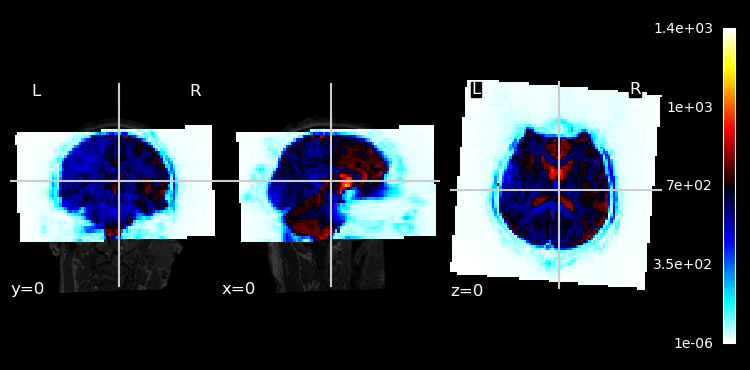

In [21]:
# Charger l'image T1
T1_image = nib.load(t1_img_path)

# Vérifier l'alignement en utilisant le premier volume de l'image fMRI corrigée
print("Vérification de l'alignement : ")
display = plotting.plot_anat(T1_image, title="T1 image with fMRI overlay")
first_volume_mcflirt = image.index_img(mcflirt_img, 0)
plotting.plot_stat_map(first_volume_mcflirt, bg_img=T1_image, display_mode='ortho', cut_coords=(0, 0, 0), draw_cross=True)
plt.show()


## 5. Assemblage du workflow

In [22]:
# Créer le workflow
preproc_workflow = Workflow(name='work_preproc', base_dir='/home/rduchadeau/Desktop/Brainhack_school/duchadeau_project/working_directory')

# Ajouter les noeuds au workflow
preproc_workflow.add_nodes([gunzip_node, bet_node, mcflirt_node])

# Connecter les noeuds
preproc_workflow.connect([
    (gunzip_node, mcflirt_node, [('out_file', 'in_file')]),
    (mcflirt_node, bet_node, [('out_file', 'in_file')])
])


    On peut maintenant utiliser le workflow au complet en appelant preproc_workflow si j'ai bien compris

## Tout d'un coup pour sub_02_sess_02: 

In [ ]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting, image
from nipype.interfaces.fsl import BET, FLIRT, MCFLIRT
from nipype.algorithms.misc import Gunzip
from nipype import Node, Workflow

# Définir les chemins
dataset_path = '/home/rduchadeau/Desktop/Brainhack_school/duchadeau_project/ds003768-download/'
fmri_path_sub_02_sess_02 = os.path.join(dataset_path, 'sub-02/func/sub-02_task-rest_run-2_bold.nii.gz')
t1_img_path = os.path.join(dataset_path, 'sub-02/anat/sub-02_T1w.nii.gz')
working_dir = '/home/rduchadeau/Desktop/Brainhack_school/duchadeau_project/working_directory'

# Fonction pour visualiser une image 3D
def visualize_3d_img(img, title):
    plotting.plot_anat(img, title=title)
    plt.show()

# Fonction pour visualiser une image 4D (premier volume)
def visualize_4d_img(img, title):
    first_volume = image.index_img(img, 0)
    plotting.plot_epi(first_volume, title=title)
    plt.show()

# Vérifier si un fichier existe déjà
def check_file_exists(filepath):
    return os.path.isfile(filepath)

# ************* Workflow initialisation *************
# Définir le noeud pour la décompression des fichiers gzip
gunzip_output_path = os.path.join(working_dir, 'decompressed_func.nii.gz')
if check_file_exists(gunzip_output_path):
    decompressed_img = nib.load(gunzip_output_path)
else:
    gunzip_node = Node(Gunzip(), name='gunzip_func')
    gunzip_node.inputs.in_file = fmri_path_sub_02_sess_02
    gunzip_res = gunzip_node.run()
    decompressed_img = nib.load(gunzip_res.outputs.out_file)
    nib.save(decompressed_img, gunzip_output_path)
visualize_4d_img(decompressed_img, "Décompressé")

# Définir le noeud pour la correction des mouvements
mcflirt_output_path = os.path.join(working_dir, 'mcflirt_corrected.nii.gz')
if check_file_exists(mcflirt_output_path):
    mcflirt_img = nib.load(mcflirt_output_path)
else:
    mcflirt_node = Node(MCFLIRT(), name='mcflirt')
    mcflirt_node.inputs.in_file = gunzip_output_path
    mcflirt_node.inputs.out_file = mcflirt_output_path
    mcflirt_res = mcflirt_node.run()
    mcflirt_img = nib.load(mcflirt_res.outputs.out_file)
visualize_4d_img(mcflirt_img, "Correction des mouvements")

# Définir le noeud pour l'alignement avec FLIRT
flirt_output_path = os.path.join(working_dir, 'flirt_aligned.nii.gz')
if check_file_exists(flirt_output_path):
    flirt_img = nib.load(flirt_output_path)
else:
    flirt_node = Node(FLIRT(), name='flirt')
    flirt_node.inputs.in_file = mcflirt_output_path
    flirt_node.inputs.reference = t1_img_path
    flirt_node.inputs.out_file = flirt_output_path
    flirt_res = flirt_node.run()
    flirt_img = nib.load(flirt_res.outputs.out_file)
visualize_3d_img(flirt_img, "Alignement avec T1")

# Extraire le premier volume de l'image corrigée des mouvements pour BET
first_vol_path = os.path.join(working_dir, 'mcflirt_first_vol.nii.gz')
if not check_file_exists(first_vol_path):
    first_volume = image.index_img(mcflirt_img, 0)
    nib.save(first_volume, first_vol_path)
else:
    first_volume = nib.load(first_vol_path)

bet_output_path = os.path.join(working_dir, 'output_brain.nii.gz')
bet_node = Node(BET(), name='extract')
bet_node.inputs.frac = 0.1
bet_node.inputs.in_file = first_vol_path
bet_node.inputs.out_file = bet_output_path
if check_file_exists(bet_output_path):
    extracted_img = nib.load(bet_output_path)
else:
    bet_res = bet_node.run()
    extracted_img = nib.load(bet_res.outputs.out_file)
visualize_3d_img(extracted_img, "Extraction du cerveau")
plotting.view_img(extracted_img, title=f"Extraction du cerveau avec frac {bet_node.inputs.frac}")


Vérification de l'alignement : 


/home/rduchadeau/miniconda3/lib/python3.12/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(


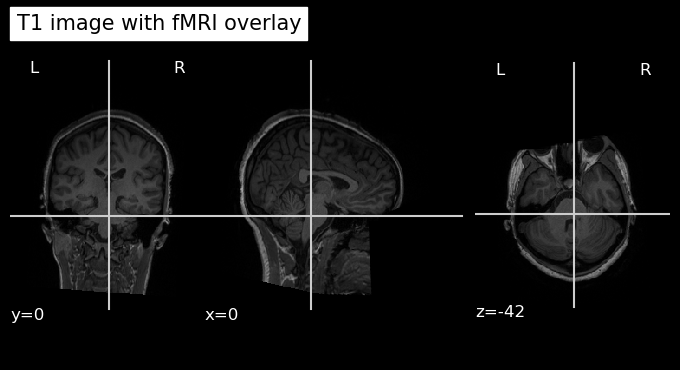

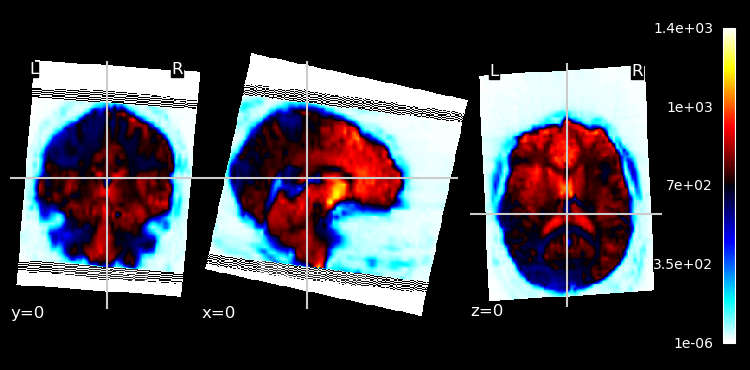

In [48]:
# Vérification de l'alignement avec l'image T1
print("Vérification de l'alignement : ")
display = plotting.plot_anat(t1_img_path, title="T1 image with fMRI overlay")
plotting.plot_stat_map(flirt_img, bg_img=t1_img_path, display_mode='ortho', cut_coords=(0, 0, 0), draw_cross=True)
plt.show()


## Try of the whole workflow for few images 

### For one subject:

240611-12:03:12,453 nipype.workflow INFO:
	 [Node] Setting-up "gunzip_func" in "/tmp/tmpj6p176j7/gunzip_func".
240611-12:03:12,457 nipype.workflow INFO:
	 [Node] Executing "gunzip_func" <nipype.algorithms.misc.Gunzip>
240611-12:03:12,469 nipype.workflow INFO:
	 [Node] Finished "gunzip_func", elapsed time 0.008223s.


/home/rduchadeau/miniconda3/lib/python3.12/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(


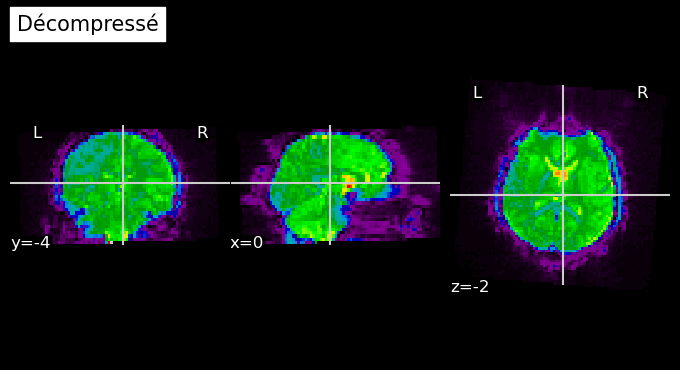

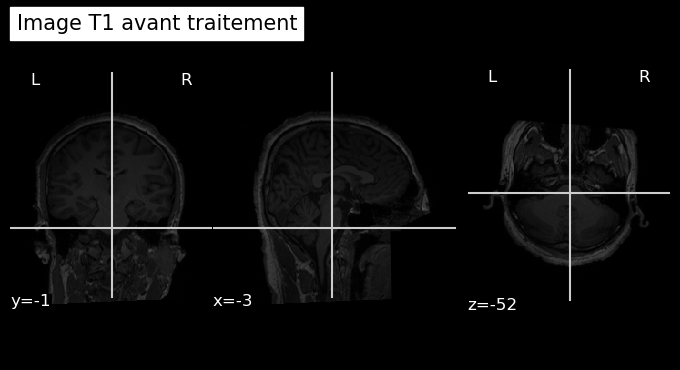

240611-12:03:22,759 nipype.workflow INFO:
	 [Node] Setting-up "flirt" in "/tmp/tmpj8xxm43q/flirt".
240611-12:03:22,762 nipype.workflow INFO:
	 [Node] Executing "flirt" <nipype.interfaces.fsl.preprocess.FLIRT>
240611-12:03:39,69 nipype.workflow INFO:
	 [Node] Finished "flirt", elapsed time 16.305779s.


/home/rduchadeau/miniconda3/lib/python3.12/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(


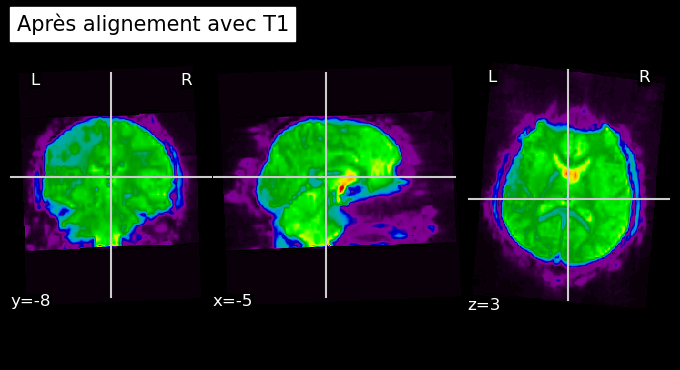

240611-12:03:47,182 nipype.workflow INFO:
	 [Node] Setting-up "extract" in "/tmp/tmpwuoa4kmh/extract".
240611-12:03:47,185 nipype.workflow INFO:
	 [Node] Executing "extract" <nipype.interfaces.fsl.preprocess.BET>
240611-12:03:51,521 nipype.workflow INFO:
	 [Node] Finished "extract", elapsed time 4.332713s.


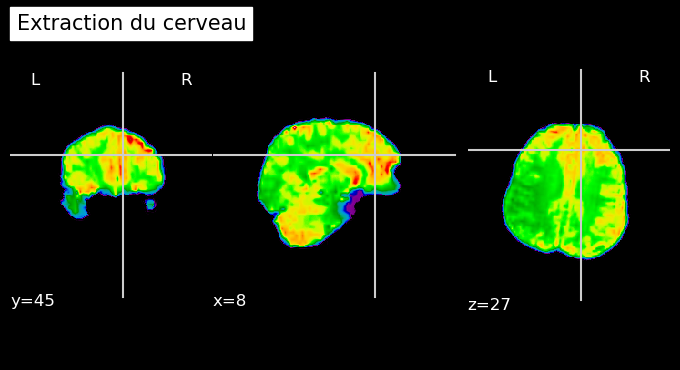

Vérification de l'alignement : 


/home/rduchadeau/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
gio: http://localhost:41275/index.html: Operation not supported


In [4]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting, image
from nipype.interfaces.fsl import BET, FLIRT
from nipype.algorithms.misc import Gunzip
from nipype import Node

# ************* PATH definition *************
labeled_data_path = '/home/rduchadeau/Desktop/Brainhack_school/duchadeau_project/fMRI_labeled_data/'
dataset_path = '/home/rduchadeau/Desktop/Brainhack_school/duchadeau_project/ds003768-download/'
subject = 'sub-01'
working_dir = '/home/rduchadeau/Desktop/Brainhack_school/duchadeau_project/working_directory'
output_dir = '/home/rduchadeau/Desktop/Brainhack_school/duchadeau_project/fmri_preprocessed_data'

t1_img_path = os.path.join(dataset_path, subject, 'anat', f'{subject}_T1w.nii.gz')
fmri_path = os.path.join(labeled_data_path, subject, 'sub-01_task-rest_run-1_sec_0_label_2.nii.gz')

# ************* Functions definition *************
# Fonction pour visualiser une image 3D
def visualize_3d_img(img, title):
    plotting.plot_epi(img, title=title)
    plt.show()

def visualize_3d_img_anat(img, title):
    plotting.plot_anat(img, title=title)
    plt.show()

# Normalisation de l'intensité
def normalize_intensity(img):
    data = img.get_fdata()
    mean_intensity = np.mean(data)
    std_intensity = np.std(data)
    normalized_data = (data - mean_intensity) / std_intensity
    normalized_img = nib.Nifti1Image(normalized_data, img.affine)
    return normalized_img

# ************* Workflow initialisation *************

# Décompression de l'image fMRI
gunzip_node = Node(Gunzip(), name='gunzip_func')
gunzip_node.inputs.in_file = fmri_path
gunzip_res = gunzip_node.run()
decompressed_img = nib.load(gunzip_res.outputs.out_file)
visualize_3d_img(decompressed_img, "Décompressé")

# Visualisation de l'image T1 avant traitement
T1_image = nib.load(t1_img_path)
visualize_3d_img_anat(T1_image, "Image T1 avant traitement")

# Alignement de l'image fMRI avec l'image T1
flirt_node = Node(FLIRT(), name='flirt')
flirt_node.inputs.in_file = gunzip_res.outputs.out_file
flirt_node.inputs.reference = t1_img_path
flirt_node.inputs.dof = 6  # Degrees of freedom
flirt_node.inputs.cost = 'normmi'  # Normalized mutual information
flirt_node.inputs.interp = 'trilinear'  # Interpolation method
flirt_node.inputs.searchr_x = [-90, 90]  # Search angles
flirt_node.inputs.searchr_y = [-90, 90]
flirt_node.inputs.searchr_z = [-90, 90]
flirt_res = flirt_node.run()
flirt_img = nib.load(flirt_res.outputs.out_file)
visualize_3d_img(flirt_img, "Après alignement avec T1")

# Extraction du cerveau directement sur l'image alignée
bet_node = Node(BET(), name='extract')
bet_node.inputs.frac = 0.4
bet_node.inputs.in_file = flirt_res.outputs.out_file
bet_res = bet_node.run()
extracted_img = nib.load(bet_res.outputs.out_file)
visualize_3d_img(extracted_img, "Extraction du cerveau")
# plotting.view_img(extracted_img, title=f"Extraction du cerveau avec frac {bet_node.inputs.frac}")
# plt.show()

# No normalisation for now
# normalized_img = normalize_intensity(extracted_img)
normalized_img = extracted_img
# visualize_3d_img(normalized_img, "Normalisation de l'intensité")

# Vérification de l'alignement avec l'image T1
print("Vérification de l'alignement : ")
# plotting.plot_stat_map(normalized_img, bg_img=t1_img_path, title="T1 image with fMRI overlay", display_mode='ortho', cut_coords=(0, 0, 0), draw_cross=True)
# plt.show()

# Note: L'image finale à utiliser pour les matrices de corrélation et les connectomes = normalized_img

# # Enregistrer l'image finale prétraitée
# subject_output_dir = os.path.join(output_dir, subject)
# os.makedirs(subject_output_dir, exist_ok=True)
# final_image_path = os.path.join(subject_output_dir, os.path.basename(fmri_path).replace('.nii.gz', '_preprocessed.nii.gz'))
# nib.save(normalized_img, final_image_path)
# print(f"L'image finale prétraitée a été enregistrée à: {final_image_path}")

# Visualisation interactive de l'image prétraitée
plotting.view_img(normalized_img, bg_img=T1_image, title="Image fMRI prétraitée").open_in_browser()


### For several subjects:

In [8]:
import os
import nibabel as nib
from nipype.interfaces.fsl import BET, FLIRT
from nipype.algorithms.misc import Gunzip
from nipype import Node

# ************* PATH definition *************
labeled_data_path = '/home/rduchadeau/Desktop/Brainhack_school/duchadeau_project/fMRI_labeled_data/'
dataset_path = '/home/rduchadeau/Desktop/Brainhack_school/duchadeau_project/ds003768-download/'
working_dir = '/home/rduchadeau/Desktop/Brainhack_school/duchadeau_project/working_directory'
output_dir = '/home/rduchadeau/Desktop/Brainhack_school/duchadeau_project/fmri_preprocessed_data'

# List of sessions
sessions = ['task-sleep_run-1', 'task-sleep_run-2']  # For testing

# List of subjects
#subjects = [f'sub-{i:02d}' for i in range(18, 34)]
subjects = ['sub-21']

# ************* Function for file loading *************
def path_fmri_images(data_dir, subject, session):
    session_dir = os.path.join(data_dir, subject)
    images_path = []
    labels = []
    
    for file in os.listdir(session_dir):
        if session in file and file.endswith('.nii.gz'):
            images_path.append(os.path.join(session_dir, file))
            
            # Extract the label from the filename
            label_str = file.split('_label_')[1].split('.nii.gz')[0]
            label = float(label_str)
            if label.is_integer():
                label = int(label)
            labels.append(label)
    
    return images_path, labels

# ************* Workflow processing for each subject *************
for subject in subjects:
    for session in sessions:
        print(f"*****\nProcessing subject: {subject}, session: {session}\n*****")

        t1_img_path = os.path.join(dataset_path, subject, 'anat', f'{subject}_T1w.nii.gz')
        all_fmri_path, labels = path_fmri_images(labeled_data_path, subject, session)
        
        # Check if the session exists for this subject
        if len(all_fmri_path) != 0:
            for i in range(len(all_fmri_path)): 
                fmri_path = all_fmri_path[i]

                try:
                    # Decompress the fMRI image
                    gunzip_node = Node(Gunzip(), name='gunzip_func')
                    gunzip_node.inputs.in_file = fmri_path
                    gunzip_res = gunzip_node.run()
                    decompressed_img = nib.load(gunzip_res.outputs.out_file)
                    
                    # Align the fMRI image with the T1 image
                    flirt_node = Node(FLIRT(), name='flirt')
                    flirt_node.inputs.in_file = gunzip_res.outputs.out_file
                    flirt_node.inputs.reference = t1_img_path
                    flirt_node.inputs.dof = 6  # Degrees of freedom
                    flirt_node.inputs.cost = 'normmi'  # Normalized mutual information
                    flirt_node.inputs.interp = 'trilinear'  # Interpolation method
                    flirt_node.inputs.searchr_x = [-90, 90]  # Search angles
                    flirt_node.inputs.searchr_y = [-90, 90]
                    flirt_node.inputs.searchr_z = [-90, 90]
                    flirt_res = flirt_node.run()
                    flirt_img = nib.load(flirt_res.outputs.out_file)

                    # Brain extraction on the aligned image
                    bet_node = Node(BET(), name='extract')
                    bet_node.inputs.frac = 0.4
                    bet_node.inputs.in_file = flirt_res.outputs.out_file
                    bet_res = bet_node.run()
                    extracted_img = nib.load(bet_res.outputs.out_file)

                    # Save the final preprocessed image
                    subject_output_dir = os.path.join(output_dir, subject)
                    os.makedirs(subject_output_dir, exist_ok=True)
                    final_image_path = os.path.join(subject_output_dir, os.path.basename(fmri_path).replace('.nii.gz', '_preprocessed.nii.gz'))
                    nib.save(extracted_img, final_image_path)
                    # print(f"The final preprocessed image has been saved to: {final_image_path}")

                except Exception as e:
                    print(f"Error processing {fmri_path}: {e}")

        else:
            print(f"**** session {session} empty for subject {subject} ****")

print("*****\nProcessing completed for all subjects.\n*****")


*****
Processing subject: sub-21, session: task-sleep_run-1
*****
**** session task-sleep_run-1 empty for subject sub-21 ****
*****
Processing subject: sub-21, session: task-sleep_run-2
*****
**** session task-sleep_run-2 empty for subject sub-21 ****
*****
Processing completed for all subjects.
*****


Vérifier qu'on a des images exploitables:

In [9]:
import os
import nibabel as nib
import numpy as np
from nilearn import plotting, image
from nipype.interfaces.fsl import BET, FLIRT
from nipype.algorithms.misc import Gunzip
from nipype import Node

# ************* PATH definition *************
fmri_preprocessed_data_path = '/home/rduchadeau/Desktop/Brainhack_school/duchadeau_project/fMRI_preprocessed_data/'
dataset_path = '/home/rduchadeau/Desktop/Brainhack_school/duchadeau_project/ds003768-download/'
subject = 'sub-30'

t1_img_path = os.path.join(dataset_path, subject, 'anat', f'{subject}_T1w.nii.gz')
fmri_path = "/home/rduchadeau/Desktop/Brainhack_school/duchadeau_project/fmri_preprocessed_data/sub-15/sub-15_task-sleep_run-2_sec_480_label_1_preprocessed.nii.gz"

# ************* Charger et plot l'image *************
image = nib.load(fmri_path)
T1_image = nib.load(t1_img_path)
plotting.view_img(image, bg_img=T1_image, title=f"{subject}").open_in_browser()

/home/rduchadeau/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
gio: http://localhost:39867/index.html: Operation not supported


RuntimeError: Failed to open nilearn plot or report in a web browser.

### Jusqu'à brain extraction

240607-15:38:23,921 nipype.workflow INFO:
	 [Node] Setting-up "gunzip_func" in "/tmp/tmpje0m4tfb/gunzip_func".
240607-15:38:23,924 nipype.workflow INFO:
	 [Node] Executing "gunzip_func" <nipype.algorithms.misc.Gunzip>
240607-15:38:23,930 nipype.workflow INFO:
	 [Node] Finished "gunzip_func", elapsed time 0.004558s.


/home/rduchadeau/miniconda3/lib/python3.12/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(


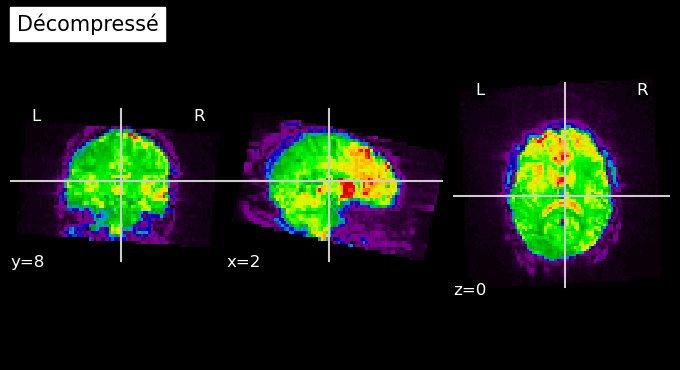

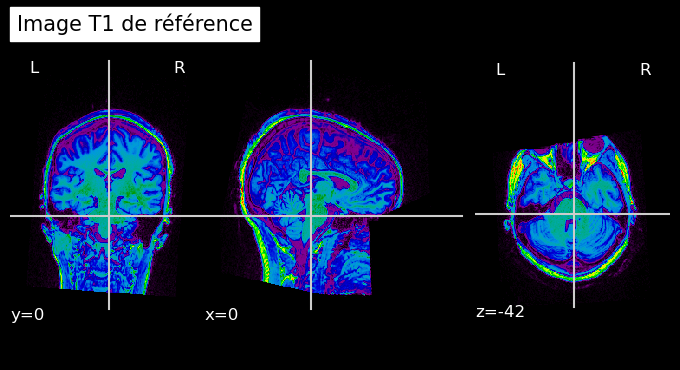

240607-15:38:29,518 nipype.workflow INFO:
	 [Node] Setting-up "flirt" in "/tmp/tmpn73iymku/flirt".
240607-15:38:29,524 nipype.workflow INFO:
	 [Node] Executing "flirt" <nipype.interfaces.fsl.preprocess.FLIRT>
240607-15:38:35,560 nipype.workflow INFO:
	 [Node] Finished "flirt", elapsed time 6.035485s.


/home/rduchadeau/miniconda3/lib/python3.12/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(


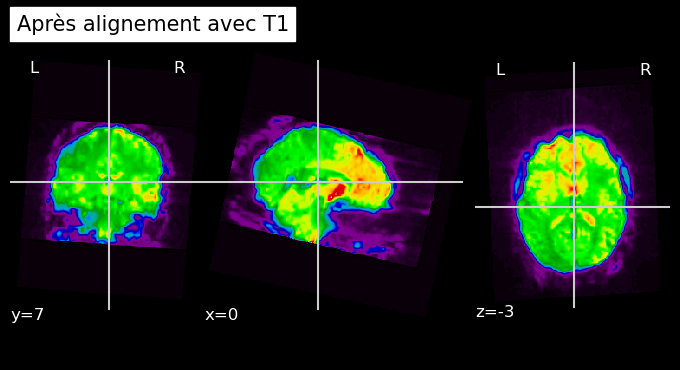

240607-15:38:40,173 nipype.workflow INFO:
	 [Node] Setting-up "extract" in "/tmp/tmplpuae55c/extract".
240607-15:38:40,187 nipype.workflow INFO:
	 [Node] Executing "extract" <nipype.interfaces.fsl.preprocess.BET>
240607-15:38:42,329 nipype.workflow INFO:
	 [Node] Finished "extract", elapsed time 2.140594s.


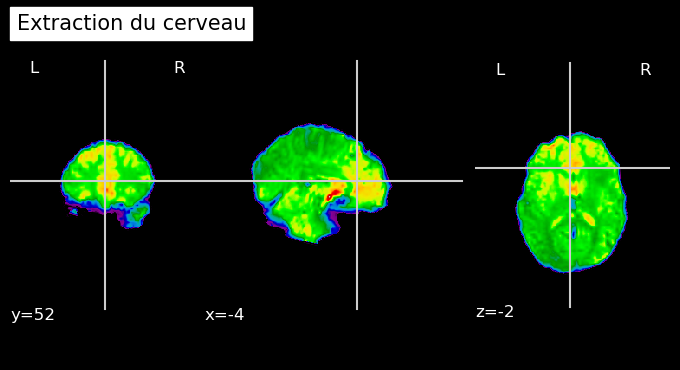

/home/rduchadeau/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/rduchadeau/miniconda3/lib/python3.12/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(
gio: http://localhost:37703/index.html: Operation not supported


In [97]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting, image
from nipype.interfaces.fsl import BET, FLIRT
from nipype.algorithms.misc import Gunzip
from nipype import Node

# ************* PATH definition *************
labeled_data_path = '/home/rduchadeau/Desktop/Brainhack_school/duchadeau_project/fMRI_labeled_data/'
dataset_path = '/home/rduchadeau/Desktop/Brainhack_school/duchadeau_project/ds003768-download/'
subject = 'sub-02'
working_dir = '/home/rduchadeau/Desktop/Brainhack_school/duchadeau_project/working_directory'
output_dir = '/home/rduchadeau/Desktop/Brainhack_school/duchadeau_project/fmri_preprocessed_data'

t1_img_path = os.path.join(dataset_path, subject, 'anat', f'{subject}_T1w.nii.gz')
fmri_path = os.path.join(labeled_data_path, subject, 'sub-02_task-rest_run-1_sec_0_label_0.nii.gz')

# ************* Functions definition *************
# Fonction pour visualiser une image 3D
def visualize_3d_img(img, title):
    plotting.plot_epi(img, title=title)
    plt.show()
    
def visualize_3d_img_anat(img, title):
    plotting.plot_anat(img, title=title)
    plt.show()

# Normalisation de l'intensité
def normalize_intensity(img):
    data = img.get_fdata()
    mean_intensity = np.mean(data)
    std_intensity = np.std(data)
    normalized_data = (data - mean_intensity) / std_intensity
    normalized_img = nib.Nifti1Image(normalized_data, img.affine)
    return normalized_img

# ************* Workflow initialisation *************

# Décompression de l'image fMRI
gunzip_node = Node(Gunzip(), name='gunzip_func')
gunzip_node.inputs.in_file = fmri_path
gunzip_res = gunzip_node.run()
decompressed_img = nib.load(gunzip_res.outputs.out_file)
visualize_3d_img(decompressed_img, "Décompressé")

# Visualisation de l'image T1 avant traitement
T1_image = nib.load(t1_img_path)
visualize_3d_img_anat(T1_image, "Image T1 de référence")

# Alignement de l'image fMRI avec l'image T1
flirt_node = Node(FLIRT(), name='flirt')
flirt_node.inputs.in_file = gunzip_res.outputs.out_file
flirt_node.inputs.reference = t1_img_path
flirt_node.inputs.dof = 12  # Degrees of freedom
flirt_node.inputs.cost = 'normmi'  # Normalized mutual information
flirt_node.inputs.interp = 'trilinear'  # Interpolation method
flirt_node.inputs.searchr_x = [-90, 90]  # Search angles
flirt_node.inputs.searchr_y = [-90, 90]
flirt_node.inputs.searchr_z = [-90, 90]
flirt_res = flirt_node.run()
flirt_img = nib.load(flirt_res.outputs.out_file)
visualize_3d_img(flirt_img, "Après alignement avec T1")

# Extraction du cerveau directement sur l'image alignée
bet_node = Node(BET(), name='extract')
bet_node.inputs.frac = 0.4
bet_node.inputs.in_file = flirt_res.outputs.out_file
bet_res = bet_node.run()
extracted_img = nib.load(bet_res.outputs.out_file)
visualize_3d_img(extracted_img, "Extraction du cerveau")
plotting.view_img(extracted_img, bg_img=T1_image, title=f"Alignement avec {flirt_node.inputs.cost}").open_in_browser()

### Essai d'extraire le cerveau avant alignement

240607-15:35:02,64 nipype.workflow INFO:
	 [Node] Setting-up "gunzip_func" in "/tmp/tmpvb9r8mek/gunzip_func".
240607-15:35:02,66 nipype.workflow INFO:
	 [Node] Executing "gunzip_func" <nipype.algorithms.misc.Gunzip>
240607-15:35:02,77 nipype.workflow INFO:
	 [Node] Finished "gunzip_func", elapsed time 0.009864s.


/home/rduchadeau/miniconda3/lib/python3.12/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(


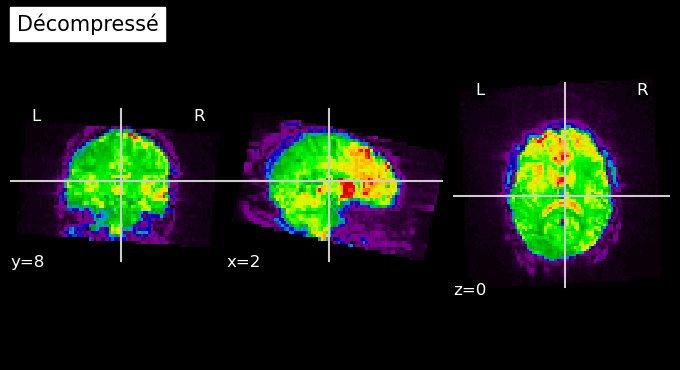

240607-15:35:02,710 nipype.workflow INFO:
	 [Node] Setting-up "bet_fmri" in "/tmp/tmpjdtcd8an/bet_fmri".
240607-15:35:02,727 nipype.workflow INFO:
	 [Node] Executing "bet_fmri" <nipype.interfaces.fsl.preprocess.BET>
240607-15:35:03,563 nipype.workflow INFO:
	 [Node] Finished "bet_fmri", elapsed time 0.834569s.


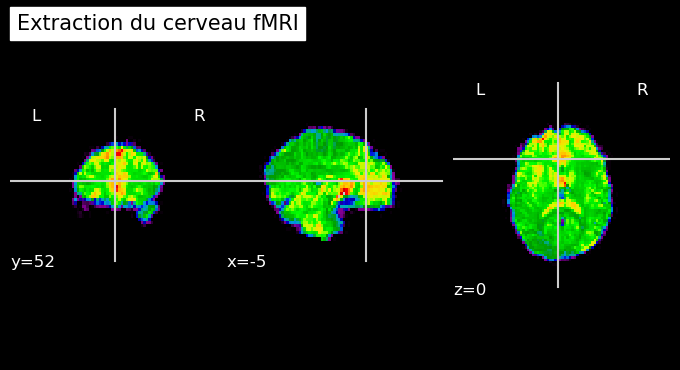

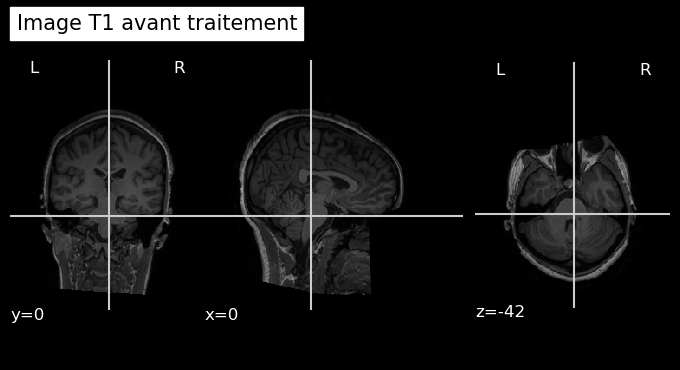

240607-15:35:09,490 nipype.workflow INFO:
	 [Node] Setting-up "bet_t1" in "/tmp/tmp_2cmdzys/bet_t1".
240607-15:35:09,504 nipype.workflow INFO:
	 [Node] Executing "bet_t1" <nipype.interfaces.fsl.preprocess.BET>
240607-15:35:11,289 nipype.workflow INFO:
	 [Node] Finished "bet_t1", elapsed time 1.782613s.


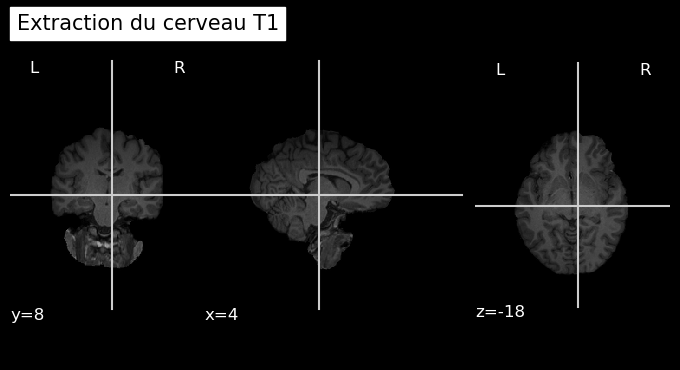

240607-15:35:15,834 nipype.workflow INFO:
	 [Node] Setting-up "flirt" in "/tmp/tmpbxp3s3d1/flirt".
240607-15:35:15,837 nipype.workflow INFO:
	 [Node] Executing "flirt" <nipype.interfaces.fsl.preprocess.FLIRT>
240607-15:35:21,853 nipype.workflow INFO:
	 [Node] Finished "flirt", elapsed time 6.014305s.


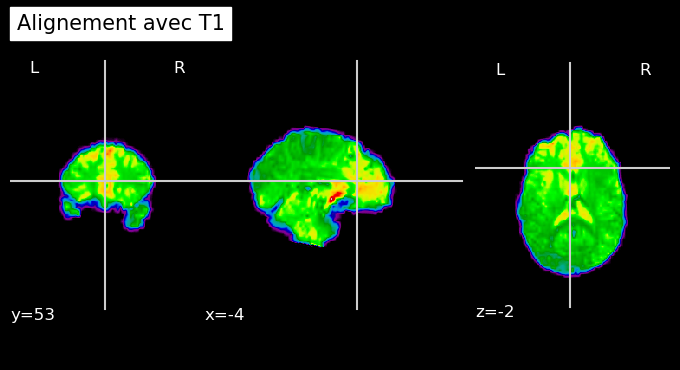

/home/rduchadeau/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/rduchadeau/miniconda3/lib/python3.12/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(
gio: http://localhost:37705/index.html: Operation not supported


In [95]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting, image
from nipype.interfaces.fsl import BET, FLIRT
from nipype.algorithms.misc import Gunzip
from nipype import Node

# ************* PATH definition *************
labeled_data_path = '/home/rduchadeau/Desktop/Brainhack_school/duchadeau_project/fMRI_labeled_data/'
dataset_path = '/home/rduchadeau/Desktop/Brainhack_school/duchadeau_project/ds003768-download/'
subject = 'sub-02'
working_dir = '/home/rduchadeau/Desktop/Brainhack_school/duchadeau_project/working_directory'
output_dir = '/home/rduchadeau/Desktop/Brainhack_school/duchadeau_project/fmri_preprocessed_data'

t1_img_path = os.path.join(dataset_path, subject, 'anat', f'{subject}_T1w.nii.gz')
fmri_path = os.path.join(labeled_data_path, subject, 'sub-02_task-rest_run-1_sec_0_label_0.nii.gz')

# ************* Functions definition *************
# Fonction pour visualiser une image 3D
def visualize_3d_img(img, title):
    plotting.plot_epi(img, title=title)
    plt.show()
    
def visualize_3d_img_anat(img, title):
    plotting.plot_anat(img, title=title)
    plt.show()

# Normalisation de l'intensité
def normalize_intensity(img):
    data = img.get_fdata()
    mean_intensity = np.mean(data)
    std_intensity = np.std(data)
    normalized_data = (data - mean_intensity) / std_intensity
    normalized_img = nib.Nifti1Image(normalized_data, img.affine)
    return normalized_img

# ************* Workflow initialisation *************

# Décompression de l'image fMRI
gunzip_node = Node(Gunzip(), name='gunzip_func')
gunzip_node.inputs.in_file = fmri_path
gunzip_res = gunzip_node.run()
decompressed_img = nib.load(gunzip_res.outputs.out_file)
visualize_3d_img(decompressed_img, "Décompressé")

# Extraction du cerveau pour l'image fMRI
bet_fmri_node = Node(BET(), name='bet_fmri')
bet_fmri_node.inputs.in_file = gunzip_res.outputs.out_file
bet_fmri_node.inputs.frac = 0.4
bet_fmri_res = bet_fmri_node.run()
bet_fmri_img = nib.load(bet_fmri_res.outputs.out_file)
visualize_3d_img(bet_fmri_img, "Extraction du cerveau fMRI")

# Visualisation de l'image T1 avant traitement
T1_image = nib.load(t1_img_path)
visualize_3d_img_anat(T1_image, "Image T1 avant traitement")

# Extraction du cerveau pour l'image T1
bet_t1_node = Node(BET(), name='bet_t1')
bet_t1_node.inputs.in_file = t1_img_path
bet_t1_node.inputs.frac = 0.4
bet_t1_res = bet_t1_node.run()
bet_t1_img = nib.load(bet_t1_res.outputs.out_file)
visualize_3d_img_anat(bet_t1_img, "Extraction du cerveau T1")

# Alignement de l'image fMRI avec l'image T1
flirt_node = Node(FLIRT(), name='flirt')
flirt_node.inputs.in_file = bet_fmri_res.outputs.out_file
flirt_node.inputs.reference = bet_t1_res.outputs.out_file
flirt_node.inputs.dof = 12  # Adjust degrees of freedom for better alignment
flirt_node.inputs.cost = 'normmi'  # Try using mutual information for cost function
flirt_res = flirt_node.run()
flirt_img = nib.load(flirt_res.outputs.out_file)
visualize_3d_img(flirt_img, "Alignement avec T1")
plotting.view_img(flirt_img, bg_img=bet_t1_img, title=f"Alignement avec {flirt_node.inputs.cost}").open_in_browser()


Vérification de l'alignement : 


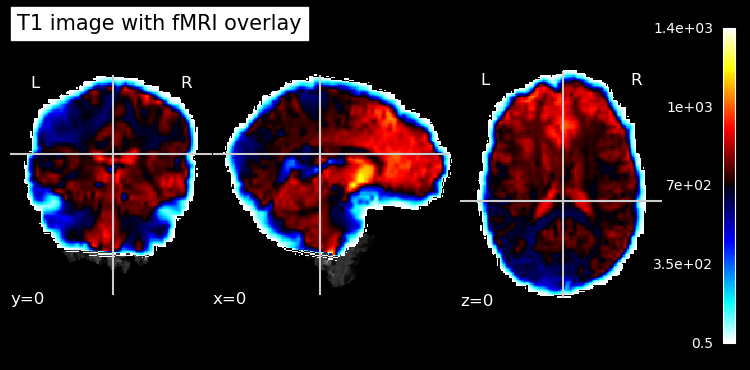

/home/rduchadeau/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/rduchadeau/miniconda3/lib/python3.12/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(
gio: http://localhost:33281/index.html: Operation not supported


RuntimeError: Failed to open nilearn plot or report in a web browser.

In [94]:

# Visualiser avec des seuils et un colormap amélioré
print("Vérification de l'alignement : ")
plotting.plot_stat_map(flirt_img, bg_img=bet_t1_img, title="T1 image with fMRI overlay", display_mode='ortho', cut_coords=(0, 0, 0), threshold=0.5, cmap='cold_hot')
plt.show()

# Sauvegarder et visualiser interactivement
plotting.view_img(flirt_img, bg_img=bet_t1_img, title="Alignement amélioré", threshold=0.5, cmap='cold_hot').open_in_browser()